# Proximal Policy Optimization

**Author:** [Ali BaniAsad](https://github.com/alibaniasad1999)<br>
**Date created:** 2024/05/24<br>
**Last modified:** 2024/05/24<br>
**Description:** Implementation of a Proximal Policy Optimization agent for the CartPole-v1 environment.

## Introduction

This code example solves the MBK (mass spring damper) environment using a Proximal Policy Optimization (PPO) agent.

### MBK

The system is controlled by applying a force within the range of +20 to -20. The system starts from a random position and speed.

### Proximal Policy Optimization

PPO is a policy gradient method and can be used for environments with either discrete or continuous action spaces.
It trains a stochastic policy in an on-policy way. Also, it utilizes the actor critic method. The actor maps the
observation to an action and the critic gives an expectation of the rewards of the agent for the observation given.
Firstly, it collects a set of trajectories for each epoch by sampling from the latest version of the stochastic policy.
Then, the rewards-to-go and the advantage estimates are computed in order to update the policy and fit the value function.
The policy is updated via a stochastic gradient ascent optimizer, while the value function is fitted via some gradient descent algorithm.
This procedure is applied for many epochs until the environment is solved.

![Algorithm](https://i.imgur.com/rd5tda1.png)

- [Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347)
- [OpenAI Spinning Up docs - PPO](https://spinningup.openai.com/en/latest/algorithms/ppo.html)

### Note

This code example uses Keras and Tensorflow v2. It is based on the PPO Original Paper,
the OpenAI's Spinning Up docs for PPO, and the OpenAI's Spinning Up implementation of PPO using Tensorflow v1.

[OpenAI Spinning Up Github - PPO](https://github.com/openai/spinningup/blob/master/spinup/algos/tf1/ppo/ppo.py)

## Libraries

For this example the following libraries are used:

1. `numpy` for n-dimensional arrays
2. `tensorflow` and `keras` for building the deep RL PPO agent
3. `gymnasium` for getting everything we need about the environment
4. `scipy.signal` for calculating the discounted cumulative sums of vectors

In [85]:
# !pip install gymnasium
# !pip install --upgrade tensorflow
# !pip install --upgrade tf-keras
# !pip install --upgrade keras

In [86]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import numpy as np
import tensorflow as tf
import gymnasium as gym
from typing import Optional
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.signal import lfilter

In [87]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

In [88]:
class MassSpringDamperEnv(gym.Env):

    def __init__(self):
        super(MassSpringDamperEnv, self).__init__()

        # System parameters
        self.step_num = None
        self.last_u = None
        self.state = None
        self.done = None
        self.m = 1.0  # Mass (kg)
        self.k = 1.0  # Spring constant (N/m)
        self.c = 0.1  # Damping coefficient (N*s/m)

        # Simulation parameters
        self.dt = 0.01  # Time step (s)
        self.max_steps = 1000  # Maximum simulation steps
        self.current_step = 0

        # Integrator
        self.integral_error = 0

        # State and action spaces
        self.action_space = gym.spaces.Box(low=-20.0, high=20.0, shape=(1,))
        self.observation_space = gym.spaces.Box(low=-100, high=100, shape=(3,))

    def step(self, u):
        # Apply control action and simulate one time step using Euler integration
        force = action[0]  * self.action_space.high[0]
        position, velocity = self.state

        acceleration = (force - self.c * velocity - self.k * position) / self.m
        velocity += acceleration * self.dt
        position += velocity * self.dt

        self.state = np.array([position, velocity])
        self.integral_error += position * self.dt

        position, velocity = (self.state + self.action_space.high[0])/(self.action_space.high[0] - self.action_space.low[0]) # normalized data

        costs = position ** 2 + 0.1 * velocity**2 \
        + 0.01 * self.integral_error**2 + 0.001 * (force**2)

        self.step_num += 1
        if self.step_num > 1000:
            self.done = True
            
        # early stop
        if sum(self.state > 20) > 0 or sum(self.state < -20) > 0:
            self.done = True
            costs -= 1e6


        return self._get_obs(), -costs, self.done, False, {}

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.state = np.random.uniform(low=-10, high=10, size=(2,))
        self.current_step = 0
        self.last_u = None
        self.done = False
        self.step_num = 0
        self.integral_error = 0


        return self._get_obs(), {}

    def _get_obs(self):
        position, velocity = (self.state + self.action_space.high[0])/(self.action_space.high[0] - self.action_space.low[0]) # normalized data
        return np.array([position, velocity, self.integral_error], dtype=np.float32)

In [89]:
# Specify the `render_mode` parameter to show the attempts of the agent in a pop-up window.
env = MassSpringDamperEnv()

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  20.0
Min Value of Action ->  -20.0


## Functions and class

In [90]:
def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.float32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )


def mlp(x, sizes, activation=keras.activations.tanh, output_activation=None):
    # Build a feedforward neural network
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)

# Define the log-probabilities function for continuous actions
def logprobabilities(mean, log_std, actions):
    std = tf.exp(log_std)
    var = std ** 2 / 5
    # print(actions.dtype)
    # print(mean.dtype)
    # print(var.dtype)
    # fix shape
    actions = tf.reshape(actions, (-1, 1))
    logp = -0.5 * (((actions - mean) ** 2) / var + 2 * log_std + tf.math.log(2 * np.pi))
    return tf.reduce_sum(logp, axis=-1)


# Sample action from actor
@tf.function
def sample_action(observation, stochastic=True):
    # Get the mean and log standard deviation from the actor network
    mean, log_std = actor(observation)

    # Convert log standard deviation to standard deviation
    if stochastic:
        std = tf.exp(log_std)
    else:
        std = 0

    # Sample a continuous action from the Gaussian distribution
    action = mean + std * tf.random.normal(shape=mean.shape)

    return mean, log_std, action


# Train the policy by maximizing the PPO-Clip objective
@tf.function
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        mean, log_std = actor(observation_buffer)
        ratio = tf.exp(
            logprobabilities(mean, log_std, action_buffer)
            - logprobability_buffer
        )
        min_advantage = tf.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )

        policy_loss = -tf.reduce_mean(
            tf.minimum(ratio * advantage_buffer, min_advantage)
        )
    actor_value = 1.0
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_grads = [tf.clip_by_value(grad, -actor_value, actor_value) for grad in policy_grads]
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    mean, log_std = actor(observation_buffer)
    kl = logprobability_buffer - logprobabilities(mean, log_std, action_buffer)
    kl = tf.reduce_sum(kl)
    return kl


# Train the value function by regression on mean-squared error
@tf.function
def train_value_function(observation_buffer, return_buffer):
    clip_value = 1.0
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = keras.ops.mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_grads = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in value_grads]
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))


## Hyperparameters

In [91]:
# Hyperparameters of the PPO algorithm
steps_per_epoch = 4000
epochs = 3
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-4
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.97
target_kl = 0.1
hidden_sizes = (64, 64)

# True if you want to render the environment
render = False

## Initializations

In [92]:
# Initialize the environment and get the dimensionality of the
# observation space and the number of possible actions
observation_dimensions = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

# Initialize the buffer
buffer = Buffer(observation_dimensions, steps_per_epoch)

# Define the observation input
observation_input = keras.Input(shape=(observation_dimensions,), dtype="float32")

# Define the actor model
dense1_actor = keras.layers.Dense(64, activation='relu')(observation_input)
dense2_actor = keras.layers.Dense(64, activation='relu')(dense1_actor)
# add mean out put with tanh and upper and lower limit # Output mean of the Gaussian distribution
mean_output = keras.layers.Dense(num_actions, activation='tanh')(dense2_actor)
log_std_output = keras.layers.Dense(num_actions, activation='tanh')(dense2_actor) # Output log standard deviation of the Gaussian distribution
actor = keras.Model(inputs=observation_input, outputs=[mean_output, log_std_output])

# Define the critic model
dense1_critic = keras.layers.Dense(64, activation='relu')(observation_input)
dense2_critic = keras.layers.Dense(64, activation='relu')(dense1_critic)
value = keras.layers.Dense(1)(dense2_critic)  # Output single value for the critic
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

# Initialize the observation, episode return and episode length
observation, _ = env.reset()
episode_return, episode_length = 0, 0

## Train

 Epoch: 1. Mean Return: [-355102.44]. Mean Length: 1000.0
 Epoch: 2. Mean Return: [-463274.25]. Mean Length: 1000.0
 Epoch: 3. Mean Return: [-447270.22]. Mean Length: 1000.0


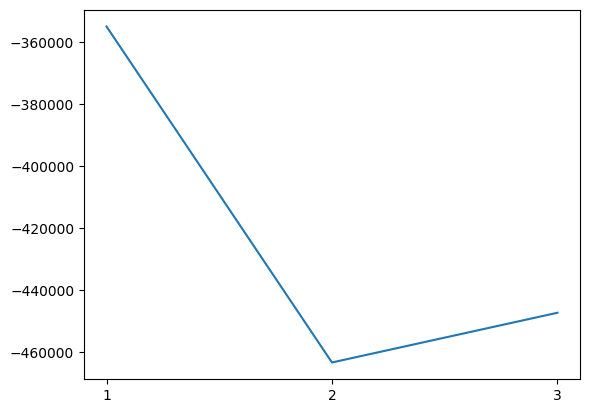

In [93]:
# reward list
rewards = []
# Iterate over the number of epochs
for epoch in range(epochs):
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0

    # Iterate over the steps of each epoch
    for t in range(steps_per_epoch):
        if render:
            env.render()

        # Get the logits, action, and take one step in the environment
        observation = observation.reshape(1, -1)
        mean, log_std, action = sample_action(observation)
        observation_new, reward, done, _, _ = env.step(action[0].numpy())
        episode_return += reward
        episode_length += 1

        # Get the value and log-probability of the action
        value_t = critic(observation)
        logprobability_t = logprobabilities(mean, log_std, action)

        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(observation, action, reward, value_t, logprobability_t)

        # Update the observation
        observation = observation_new

        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal or (t == steps_per_epoch - 1):
            last_value = 0 if done else critic(observation.reshape(1, -1))
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            sum_length += episode_length
            num_episodes += 1
            observation, _ = env.reset()
            episode_return, episode_length = 0, 0

    # Get values from the buffer
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = buffer.get()

    # Update the policy and implement early stopping using KL divergence
    for _ in range(train_policy_iterations):
        kl = train_policy(
            observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
        )
        if kl > 1.5 * target_kl:
            # Early Stopping
            break

    # Update the value function
    for _ in range(train_value_iterations):
        train_value_function(observation_buffer, return_buffer)

    # Print mean return and length for each epoch
    print(
        f" Epoch: {epoch + 1}. Mean Return: {sum_return / num_episodes}. Mean Length: {sum_length / num_episodes}"
    )
    rewards.append(sum_return / num_episodes)

# Close the environment
env.close()

# plot rewards
ax = plt.figure().gca()
plt.plot(np.linspace(1, epochs, epochs), rewards)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [94]:
# test the agent
observation, _ = env.reset()
done = False
total_reward = 0
render = False
states = []
actions = []
while not done:
    mean, log_std, action = sample_action(observation.reshape(1, -1), stochastic=False)
    observation, reward, done, _, _ = env.step(action[0].numpy())
    total_reward += reward
    states.append(observation)
    actions.append(action)
    if render:
        env.render()
print("Total Reward: ", total_reward)

Total Reward:  tf.Tensor([-343809.66], shape=(1,), dtype=float32)


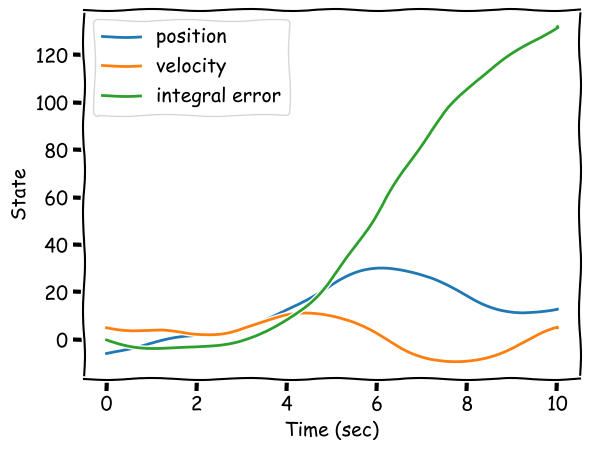

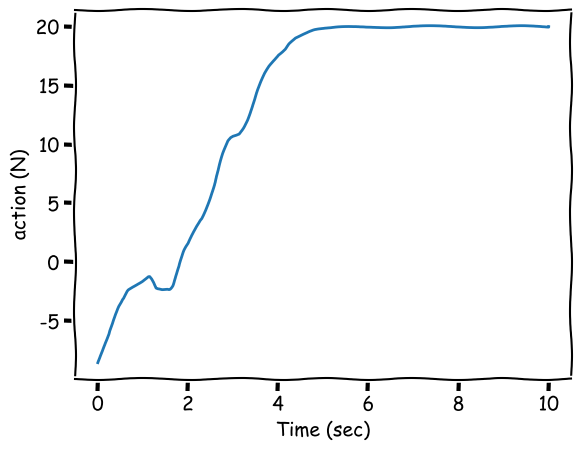

In [95]:
# Use XKCD style for hand-drawn look
dt = env.dt
time = np.arange(0, len(states)*dt, dt)
with plt.xkcd():
    plt.plot(time, np.array(states)[:, :, 0])
    plt.xlabel("Time (sec)")
    plt.ylabel("State")
    plt.legend(["position", "velocity", "integral error"])
    plt.show()

# Use XKCD style for hand-drawn look
with plt.xkcd():
    plt.plot(time, np.array(actions)[:, :, 0])
    plt.xlabel("Time (sec)")
    plt.ylabel("action (N)")
    plt.show()